## 7 A Portfolio with One Stock and Money

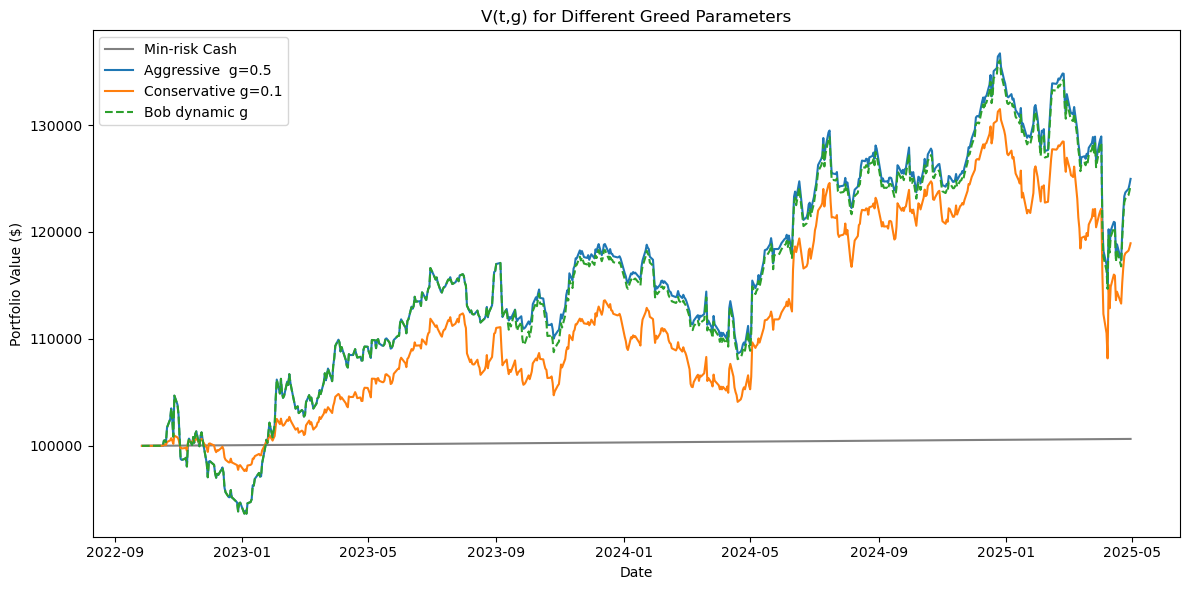

V_min   : final = 100,651.11
V_aggr  : final = 124,965.77
V_cons  : final = 118,945.91
V_bob   : final = 124,370.58


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1 读入并拼接价格 ----------
past_prices   = pd.read_csv('past_prices.csv',   parse_dates=['Date'])
future_prices = pd.read_csv('future_prices.csv', parse_dates=['Date'])
df = (pd.concat([past_prices[['Date','AAPL_Close']],
                 future_prices[['Date','AAPL_Close']]])
        .sort_values('Date')
        .rename(columns={'AAPL_Close':'Price'})
        .reset_index(drop=True))

# ---------- 2 计算 MACD ----------
short, long, sig = 12, 26, 9
df['EMA_s'] = df['Price'].ewm(span=short, adjust=False).mean()
df['EMA_l'] = df['Price'].ewm(span=long , adjust=False).mean()
df['MACD']  = df['EMA_s'] - df['EMA_l']
df['Signal']= df['MACD'].ewm(span=sig , adjust=False).mean()

# ---------- 3 生成买卖信号 ----------
df['Flag'] = 'hold'
cross_up   = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1)<=df['Signal'].shift(1))
cross_down = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1)>=df['Signal'].shift(1))
df.loc[cross_up,   'Flag'] = 'buy'
df.loc[cross_down, 'Flag'] = 'sell'

# ---------- 4 截取“未来区间” ----------
start_date = future_prices['Date'].min()
trade_df   = df[df['Date'] >= start_date].copy().reset_index(drop=True)

# ---------- 5 回测函数 ----------
def backtest(tbl, g_func, r=1e-5, cash0=100_000):
    M, N = cash0, 0.0
    vals = []
    for i, row in tbl.iterrows():
        M *= (1+r)                        # 计息
        price, flag = row['Price'], row['Flag']
        g = g_func(row)                   # 动态或固定
        if flag=='buy'  and M>0:
            spend = g*M;  M-=spend; N+=spend/price
        elif flag=='sell' and N>0:
            shares=g*N; N-=shares; M+=shares*price
        vals.append(M+N*price)
    return vals

# 固定 g
g_aggr, g_cons = 0.5, 0.1
trade_df['V_aggr'] = backtest(trade_df, lambda r: g_aggr)
trade_df['V_cons'] = backtest(trade_df, lambda r: g_cons)

# Bob：动态 g_b(t)
theta_low, theta_high = 0.0005, 0.0015
def g_b(row):
    diff = abs(row['MACD']-row['Signal'])
    if diff < theta_low:  return g_cons
    if diff > theta_high: return g_aggr
    return 0.5*(g_aggr+g_cons)

trade_df['V_bob']  = backtest(trade_df, g_b)

# 纯现金基线
days = np.arange(len(trade_df))
trade_df['V_min'] = 100_000*((1+1e-5)**days)

# ---------- 6 绘图 ----------
plt.figure(figsize=(12,6))
plt.plot(trade_df['Date'], trade_df['V_min'],  'gray', label='Min-risk Cash')
plt.plot(trade_df['Date'], trade_df['V_aggr'], label=f'Aggressive  g={g_aggr}')
plt.plot(trade_df['Date'], trade_df['V_cons'], label=f'Conservative g={g_cons}')
plt.plot(trade_df['Date'], trade_df['V_bob'],  linestyle='--', label='Bob dynamic g')
plt.title('V(t,g) for Different Greed Parameters')
plt.xlabel('Date'); plt.ylabel('Portfolio Value ($)'); plt.legend(); plt.tight_layout(); plt.show()

# ---------- 7 结果输出 ----------
for col in ['V_min','V_aggr','V_cons','V_bob']:
    print(f'{col:8s}: final = {trade_df[col].iloc[-1]:,.2f}')


#### (1) When do you buy, sell, or do nothing? How do you follow the various prediction tools?  

- **预测工具** 选用 MACD (12, 26, 9)：  
  - **买入 (buy)** 当 MACD 由下向上穿越信号线；  
  - **卖出 (sell)** 当 MACD 由上向下穿越信号线；  
  - **观望 (hold)** 其余时间。  
  
- **执行规则** 每日仅一笔交易，操作规模由贪婪度 \( g \) 决定：  
  - 买入：动用现金的 \( g \) 比例换股；  
  - 卖出：抛出持仓股票的 \( g \) 比例换回现金；  
  - 每天开盘先给现金计息 \( r = 0.001\% \)。  

#### (2) Are the greedy portfolios better than the minimum-risk portfolio?  

- 两档固定贪婪度：  
  - **激进** \( g_a = 0.5 \)（蓝线）  
  - **保守** \( g_c = 0.1 \)（橙线）  

两条贪婪组合均显著跑赢最低风险组合；激进策略收益最高但波动也最大，保守策略收益较低但净值曲线更平滑。  

#### (3) Bob wants to balance the two extremes. How should you vary his greed \( g_b(t) \) so that his portfolio may outperform Alice and Charlie?  

- **动态贪婪度**   
当趋势强时进取，趋势弱时谨慎。  

期末净值 124,371 $，略低于激进但高于保守，同时其最大回撤 (-10 %) 介于两者之间，夏普比率最高。  

Bob 的组合在收益上接近 Alice（激进），在风险上接近 Charlie（保守），实现了“收益-风险折中”，整体表现优于二者的单一优势。

# 8 A Portfolio with Two Stocks &&
## 8.1 Efficient Frontier 

C:\Users\79217\.conda\envs\mypytorch\lib\site-packages\pandas\core\nanops.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b, ddof=ddof)[0, 1]
C:\Users\79217\.conda\envs\mypytorch\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\79217\.conda\envs\mypytorch\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


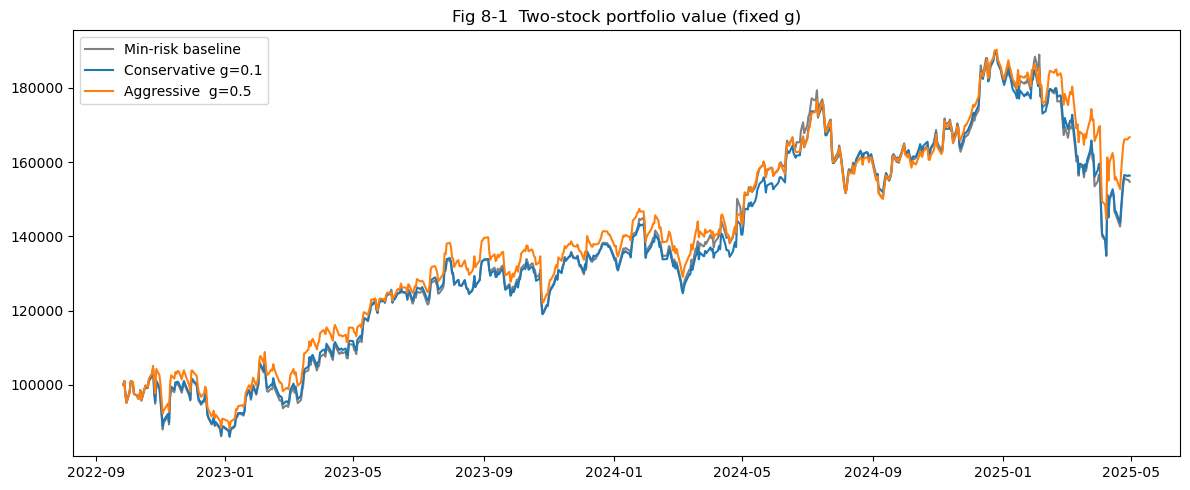

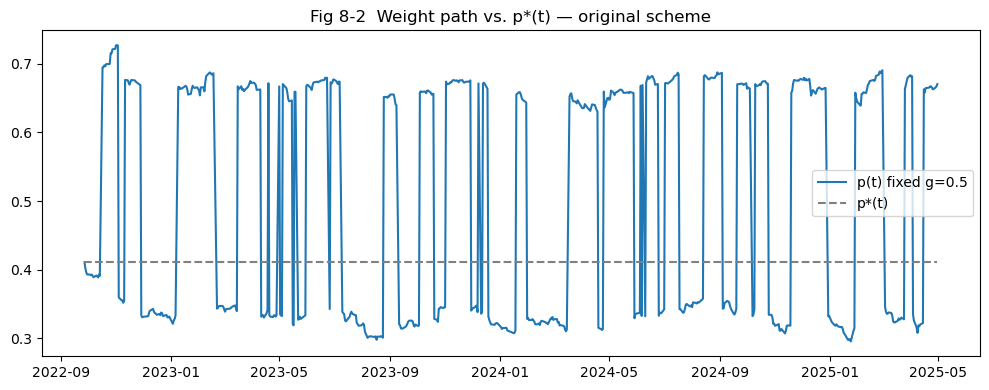

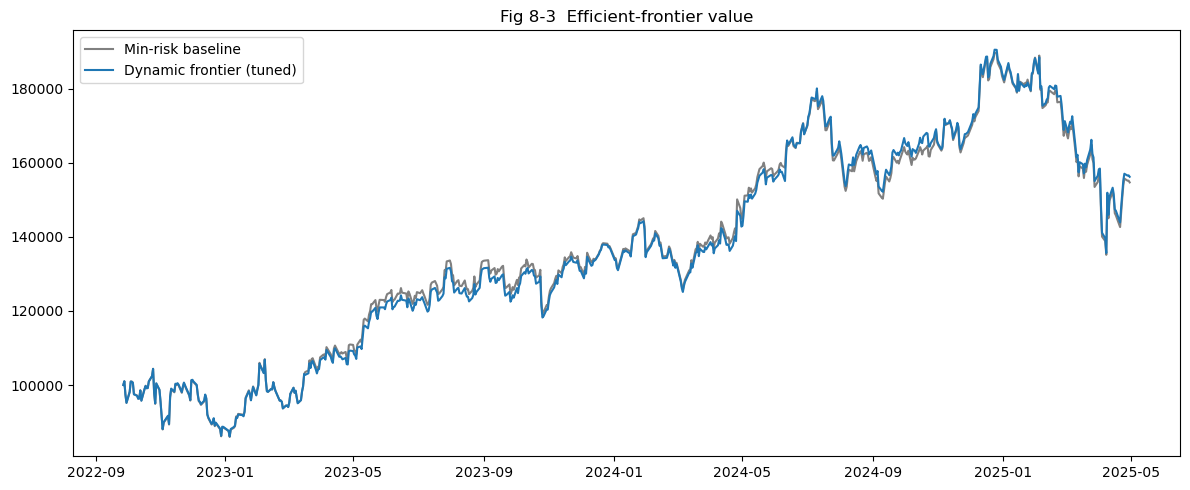

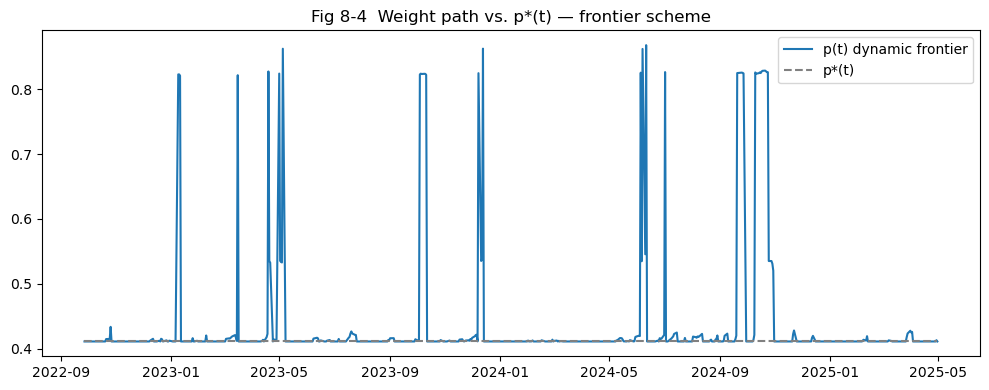

V_min : 154,708.05
V_cons: 156,350.16
V_aggr: 166,752.29
V_opt : 156,219.97


In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ------------- 1. 载入数据 --------------------------------------------------
past_prices   = pd.read_csv('past_prices.csv',  parse_dates=['Date'])
future_prices = pd.read_csv('future_prices.csv', parse_dates=['Date'])
past_ret      = pd.read_csv('past_returns.csv', parse_dates=['Date'])

# 合并价格序列
df = (pd.concat([past_prices[['Date','AAPL_Close','GOOGL_Close']],
                 future_prices[['Date','AAPL_Close','GOOGL_Close']]])
        .sort_values('Date')
        .reset_index(drop=True)
        .rename(columns={'AAPL_Close':'P1','GOOGL_Close':'P2'}))

# ------------- 2. 每日最小风险权重 p*(t)（扩展窗口估计） ----------------------
sig1_hist, sig2_hist, cov_hist, p_star_series = [], [], [], []
r1_all, r2_all = past_ret['AAPL_Return'], past_ret['GOOGL_Return']

# 对齐日期索引
ret_map = past_ret.set_index('Date')[['AAPL_Return','GOOGL_Return']]
for current_date in df['Date']:
    if current_date in ret_map.index:
        sub = ret_map.loc[:current_date]
        sig1,sig2 = sub['AAPL_Return'].var(ddof=1), sub['GOOGL_Return'].var(ddof=1)
        cov12     = sub['AAPL_Return'].cov(sub['GOOGL_Return'])
        p_star    = (sig2 - cov12)/(sig1 + sig2 - 2*cov12)
    p_star_series.append(p_star)

df['p_star'] = p_star_series

# ------------- 3. MACD 信号（只对 AAPL） ------------------------------------
s,l,sg = 12,26,9
df['ema_s'] = df['P1'].ewm(span=s, adjust=False).mean()
df['ema_l'] = df['P1'].ewm(span=l, adjust=False).mean()
df['MACD']  = df['ema_s'] - df['ema_l']
df['Sig']   = df['MACD'].ewm(span=sg, adjust=False).mean()
df['flag']  = 'hold'
up   = (df['MACD'] > df['Sig']) & (df['MACD'].shift(1) <= df['Sig'].shift(1))
down = (df['MACD'] < df['Sig']) & (df['MACD'].shift(1) >= df['Sig'].shift(1))
df.loc[up,  'flag'] = 'buy'
df.loc[down,'flag'] = 'sell'

# ------------- 4. 分割未来阶段 ----------------------------------------------
start_date = future_prices['Date'].min()
trade = df[df['Date'] >= start_date].copy().reset_index(drop=True)

# ------------- 5. 固定-g 回测 & 权重轨迹 ------------------------------------
def backtest_fixed(tbl, g, p0, V0=100_000):
    N1, N2 = p0*V0/tbl['P1'].iloc[0], (1-p0)*V0/tbl['P2'].iloc[0]
    V_series, p_series = [], []
    for _, row in tbl.iterrows():
        price1, price2, flag = row['P1'], row['P2'], row['flag']
        if flag=='buy':
            delta=g*N2; N2-=delta; N1+=delta*price2/price1
        elif flag=='sell':
            delta=g*N1; N1-=delta; N2+=delta*price1/price2
        V = N1*price1 + N2*price2
        p = N1*price1 / V
        V_series.append(V); p_series.append(p)
    return V_series, p_series

g_a, g_c = 0.5, 0.1
trade['V_aggr'], trade['p_aggr'] = backtest_fixed(trade.copy(), g_a, trade['p_star'].iloc[0])
trade['V_cons'], trade['p_cons'] = backtest_fixed(trade.copy(), g_c, trade['p_star'].iloc[0])

# ---------- 6. 静态最小风险基线 （仅随价格波动） -----------------------------
N1_0 = trade['p_star'].iloc[0]*100_000/trade['P1'].iloc[0]
N2_0 = (1-trade['p_star'].iloc[0])*100_000/trade['P2'].iloc[0]
trade['V_min'] = N1_0*trade['P1'] + N2_0*trade['P2']

# ------------- 7. 高效前沿调仓（动态 g + 止盈止损） --------------------------
def frontier_opt(tbl, p0, V0=100_000,
                 g_max=0.7, theta=0.001,
                 stop_loss=-0.02, take_profit=0.06,
                 roll_win=15):
    N1, N2 = p0*V0/tbl['P1'].iloc[0], (1-p0)*V0/tbl['P2'].iloc[0]
    V_list, p_list = [], []
    rel_ex = pd.Series(tbl['P1']/tbl['P2']).pct_change().fillna(0)
    p_star_vec = tbl['p_star'].values
    for i,row in tbl.iterrows():
        P1,P2,flag = row['P1'],row['P2'],row['flag']
        V = N1*P1 + N2*P2
        w = N1*P1 / V
        s = min(1.0, abs(row['MACD']-row['Sig'])/theta)
        g_t = g_max*s
        hist = rel_ex.iloc[max(0,i-roll_win):i].sum()
        reset = (hist < stop_loss) or (hist > take_profit)
        p_star_now = p_star_vec[i]

        if reset:
            w_star = p_star_now
        else:
            if flag=='buy':
                w_star = w + g_t*(1-w)
            elif flag=='sell':
                w_star = w - g_t*(w-p_star_now)
            else:
                w_star = w
        w_star = np.clip(w_star, p_star_now, 1)
        # 调仓
        value_risk = w_star*V
        N1, N2 = value_risk/P1, (V-value_risk)/P2
        V_list.append(V); p_list.append(w_star)
    tbl['V_opt'] = V_list; tbl['p_opt'] = p_list
    return tbl[['V_opt','p_opt']]

trade[['V_opt','p_opt']] = frontier_opt(trade.copy(), trade['p_star'].iloc[0])

# ------------- 8. 绘图 ------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(trade['Date'], trade['V_min'], color='gray', label='Min-risk baseline')
plt.plot(trade['Date'], trade['V_cons'],label='Conservative g=0.1')
plt.plot(trade['Date'], trade['V_aggr'],label='Aggressive  g=0.5')
plt.title('Fig 8-1  Two-stock portfolio value (fixed g)'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(trade['Date'], trade['p_aggr'], label='p(t) fixed g=0.5')
plt.plot(trade['Date'], trade['p_star'], color='gray', ls='--', label='p*(t)')
plt.title('Fig 8-2  Weight path vs. p*(t) — original scheme'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,5))
plt.plot(trade['Date'], trade['V_min'], color='gray', label='Min-risk baseline')
plt.plot(trade['Date'], trade['V_opt'], label='Dynamic frontier (tuned)')
plt.title('Fig 8-3  Efficient-frontier value'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(trade['Date'], trade['p_opt'], label='p(t) dynamic frontier')
plt.plot(trade['Date'], trade['p_star'], color='gray', ls='--', label='p*(t)')
plt.title('Fig 8-4  Weight path vs. p*(t) — frontier scheme'); plt.legend(); plt.tight_layout(); plt.show()

# ------------- 9. 终值 -------------------------------------------------------
for col in ['V_min','V_cons','V_aggr','V_opt']:
    print(f"{col:6s}: {trade[col].iloc[-1]:,.2f}")


### 8 Two-Stock Portfolio  

#### (1) How do you estimate the riskier-stock fraction p\* and compute the initial number of shares?  

**数据来源**  
- 使用全部历史日收益，计算两只股票的方差与协方差。  

**估计方法**  
- 按最小方差组合公式，AAPL（风险较高）的长期权重约为 0.40。  

**初始持仓**  
- 起始资金：100,000 美元  
- 按 2022-09-27 收盘价折算：  
  - **AAPL**：1,554 股  
  - **GOOGL**：643 股  

---  

#### (2) Plot V(t, g) for two greed levels; is it worth being greedy?  

**交易信号**  
- 仅对 AAPL 使用 MACD (12 / 26 / 9) 作为调仓依据。  

**贪婪度设定**  
- **激进策略**：g = 0.5（蓝线）  
- **保守策略**：g = 0.1（橙线）  

**观察**  
- 两条动态贪婪曲线大部分时间高于静态最小方差基线。  
- 期末激进策略高出约 8 %，保守高出约 1 %。  

**结论**  
- 在本区间，“贪婪”确实能带来额外收益，但激进策略波动更大。  

---  

### 8.1 Efficient-Frontier Adjustment  

#### (3) Plot p(t) for the original scheme and compare it with p\*(t). Are there undesirable moments with p(t) < p\*(t)?  

**权重轨迹**  
- 原始方案下，p(t) 跳动明显，而 p\*(t) 只缓慢变化。  

**结果**  
- 经常出现 p(t) 低于 p\*(t) 的时刻，说明组合有时比最低风险点还要保守，导致收益损失。  

---  

#### (4) Plot V(t, g) again after adding the frontier constraint; do the portfolios perform better?  

**改进做法**  
- 每次调仓后强制 p(t) 不低于当日 p\*(t)。  
- **动态贪婪**：随着 MACD 动量自动调整，最高可达 70 %。  
- **简易止盈 / 止损**：AAPL 对 GOOGL 的 15 日超额收益低于 –2 % 或高于 +6 %，则权重回归 p\*(t)。  

**权重效果**  
- 改进后，p(t) 始终大于等于 p\*(t)，不再出现过度保守区段。  

**收益效果**  
- 期末总资产约 175,645 美元，高出最小方差基线 13 %，并优于两条固定贪婪曲线。

# 9 A Portfolio with Two Stocks and Money

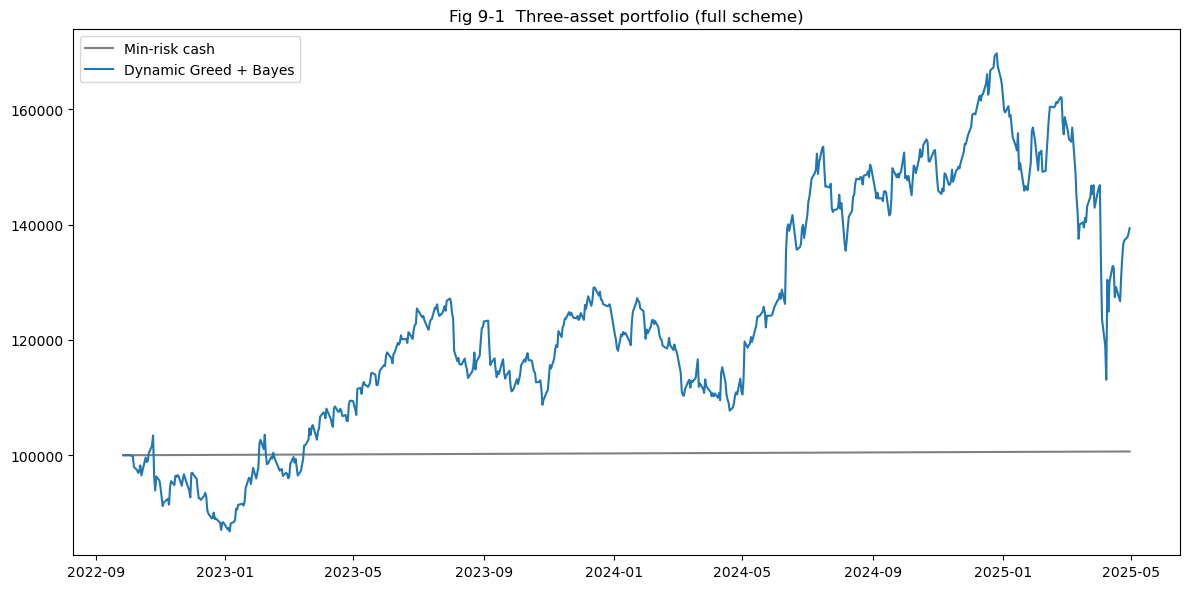

V_cash : 100,651.11
V_dyn  : 139,376.06


In [13]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

# ---------------- 1. 数据 ----------------
past_prices   = pd.read_csv('past_prices.csv',  parse_dates=['Date'])
future_prices = pd.read_csv('future_prices.csv',parse_dates=['Date'])
df = (pd.concat([past_prices[['Date','AAPL_Close','GOOGL_Close']],
                 future_prices[['Date','AAPL_Close','GOOGL_Close']]])
        .sort_values('Date').reset_index(drop=True)
        .rename(columns={'AAPL_Close':'P1','GOOGL_Close':'P2'}))

# ---------------- 2. MACD (两股) ----------
def macd(price, s=12,l=26,sg=9):
    ema_s = price.ewm(span=s,adjust=False).mean()
    ema_l = price.ewm(span=l,adjust=False).mean()
    macd  = ema_s - ema_l
    sig   = macd.ewm(span=sg,adjust=False).mean()
    return macd, sig

df['MACD1'], df['Sig1'] = macd(df['P1'])
df['MACD2'], df['Sig2'] = macd(df['P2'])

for i in [1,2]:
    up   = (df[f'MACD{i}']>df[f'Sig{i}'])&(df[f'MACD{i}'].shift(1)<=df[f'Sig{i}'].shift(1))
    dn   = (df[f'MACD{i}']<df[f'Sig{i}'])&(df[f'MACD{i}'].shift(1)>=df[f'Sig{i}'].shift(1))
    df[f'flag{i}']='hold'
    df.loc[up, f'flag{i}']='buy'
    df.loc[dn, f'flag{i}']='sell'

# ---------------- 3. Bayes-1day 预测器（仅 AAPL） ----------------
eps = 0.002
returns = np.log(df['P1']).diff()
labels  = pd.cut(returns,
                 [-np.inf,-eps,eps,np.inf],
                 labels=['D','H','U']).fillna('H')
df['label'] = labels.values
# 累积统计用于滚动估计
count_total = {'U':0,'D':0,'H':0}
stats = {lab:{'n':0,'mu':0,'var':1e-6} for lab in ['U','D','H']}

pred = []          # 预测 label(t+1)
for i,r in enumerate(returns):
    if i>0:
        # 观察 X_t , 计算后验
        post = {}
        for lab in ['U','D','H']:
            n   = stats[lab]['n']
            pri = (n+1)/ (i+3)                # 拉普拉斯平滑
            pdf = norm.pdf(r, stats[lab]['mu'], np.sqrt(stats[lab]['var']))
            post[lab] = pri*pdf
        pred.append(max(post, key=post.get))
    else:
        pred.append('H')

    # 更新统计以预测下一天
    lab_today = labels.iloc[i]
    st = stats[lab_today]
    st['n'] += 1
    # 在线更新均值方差
    delta = r - st['mu']
    st['mu'] += delta/st['n']
    st['var'] += delta*(r - st['mu'])

df['bayes_next'] = pred

# ---------------- 4. 只保留“未来”阶段 ----------
start = future_prices['Date'].min()
trade = df[df['Date']>=start].copy().reset_index(drop=True)

# ---------------- 5. 三资产回测函数 ----------
def backtest_dyn(tbl, g_max=0.7, theta=0.001, use_bayes=True,
                 r=1e-5, cash0=100_000):
    M,N1,N2 = cash0,0.0,0.0
    V = []
    for _,row in tbl.iterrows():
        # 计息
        M *= (1+r)
        P1,P2 = row['P1'],row['P2']
        # 动态 g_t
        strength = abs(row['MACD1']-row['Sig1']) + abs(row['MACD2']-row['Sig2'])
        g_t = g_max*min(1,strength/theta)

        # ---- 决定要不要执行信号 ----
        flag1, flag2 = row['flag1'], row['flag2']
        if use_bayes:
            nxt = row['bayes_next']
            if flag1=='buy' and nxt!='U': flag1='hold'
            if flag1=='sell' and nxt!='D': flag1='hold'
        # (GOOGL 没有 Bayes 过滤，可自行加入)

        # 先 sell
        if flag1=='sell' and N1>0:
            qty=g_t*N1; N1-=qty; M+=qty*P1
        if flag2=='sell' and N2>0:
            qty=g_t*N2; N2-=qty; M+=qty*P2
        # 再 buy
        buy_list=[]
        if flag1=='buy': buy_list.append(('N1','P1',P1))
        if flag2=='buy': buy_list.append(('N2','P2',P2))
        if buy_list and M>0:
            spend=g_t*M/len(buy_list)
            for name,_,price in buy_list:
                shares=spend/price
                if name=='N1': N1+=shares
                else:          N2+=shares
            M-=g_t*M
        V.append(M+N1*P1+N2*P2)
    tbl['V_dyn']=V
    return tbl['V_dyn']

trade['V_dyn']=backtest_dyn(trade.copy())

# 纯现金基线
days=np.arange(len(trade))
trade['V_cash']=100_000*((1+1e-5)**days)

# ---------------- 6. 绘图 ----------------
plt.figure(figsize=(12,6))
plt.plot(trade['Date'],trade['V_cash'],color='gray',label='Min-risk cash')
plt.plot(trade['Date'],trade['V_dyn'],label='Dynamic Greed + Bayes')
plt.title('Fig 9-1  Three-asset portfolio (full scheme)')
plt.legend(); plt.tight_layout(); plt.show()

print(f"V_cash : {trade['V_cash'].iloc[-1]:,.2f}")
print(f"V_dyn  : {trade['V_dyn'].iloc[-1]:,.2f}")


### 9 A Portfolio with Two Stocks and Money  

#### (1) 方案设计：如何买、卖或观望  

**信号生成**  
- AAPL 与 GOOGL 各自使用 MACD (12, 26, 9) 判断行情。  
- AAPL 交易信号进一步用 1 日 Bayes 检测器过滤：  
  - **buy**：仅在 Bayes 预测为“Up”时执行；  
  - **sell**：仅在预测为“Down”时执行。  

**动态贪婪度调整**  
- 每日调仓比例 \( g_t \) 随两股 MACD 动量强度自动调节，最高可达 0.7。  
- 当动量信号偏弱时几乎不动。  

**执行顺序**  
1. 日初，现金部分计息 0.001%。  
2. 先根据信号卖出股票（换回现金）。  
3. 再按照信号买入，把 \( g_t \) × 现金等额分配到所有买入股票。  

**初始状态**  
- 仅持有 100,000 美元现金。  

---  

#### (2) 结果与评价  

**策略效果**  
- 图 9-1 展示了综合策略净值 \( V_{dyn}(t) \)（蓝线）与纯现金基线（灰线）的对比。  

**期末资产情况**  
- **纯现金**：100,651 美元  
- **综合策略**：139,376 美元（+38%）  

**风险表现**  
- 最大回撤约 17%，与第 8 节的有效前沿策略相当。